In [1]:
import calendar
import os

import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [13]:
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

In [4]:
try:
    df = pd.read_csv(os.path.join("..", "data", "deaths_and_temps_england_wales.csv"))
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("deaths_and_temps_england_wales.csv"))

df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

# split into separate dataframes for pre and post onset of COVID-19
pre = df[df.index < "2020"]
post = df[df.index >= "2020"]

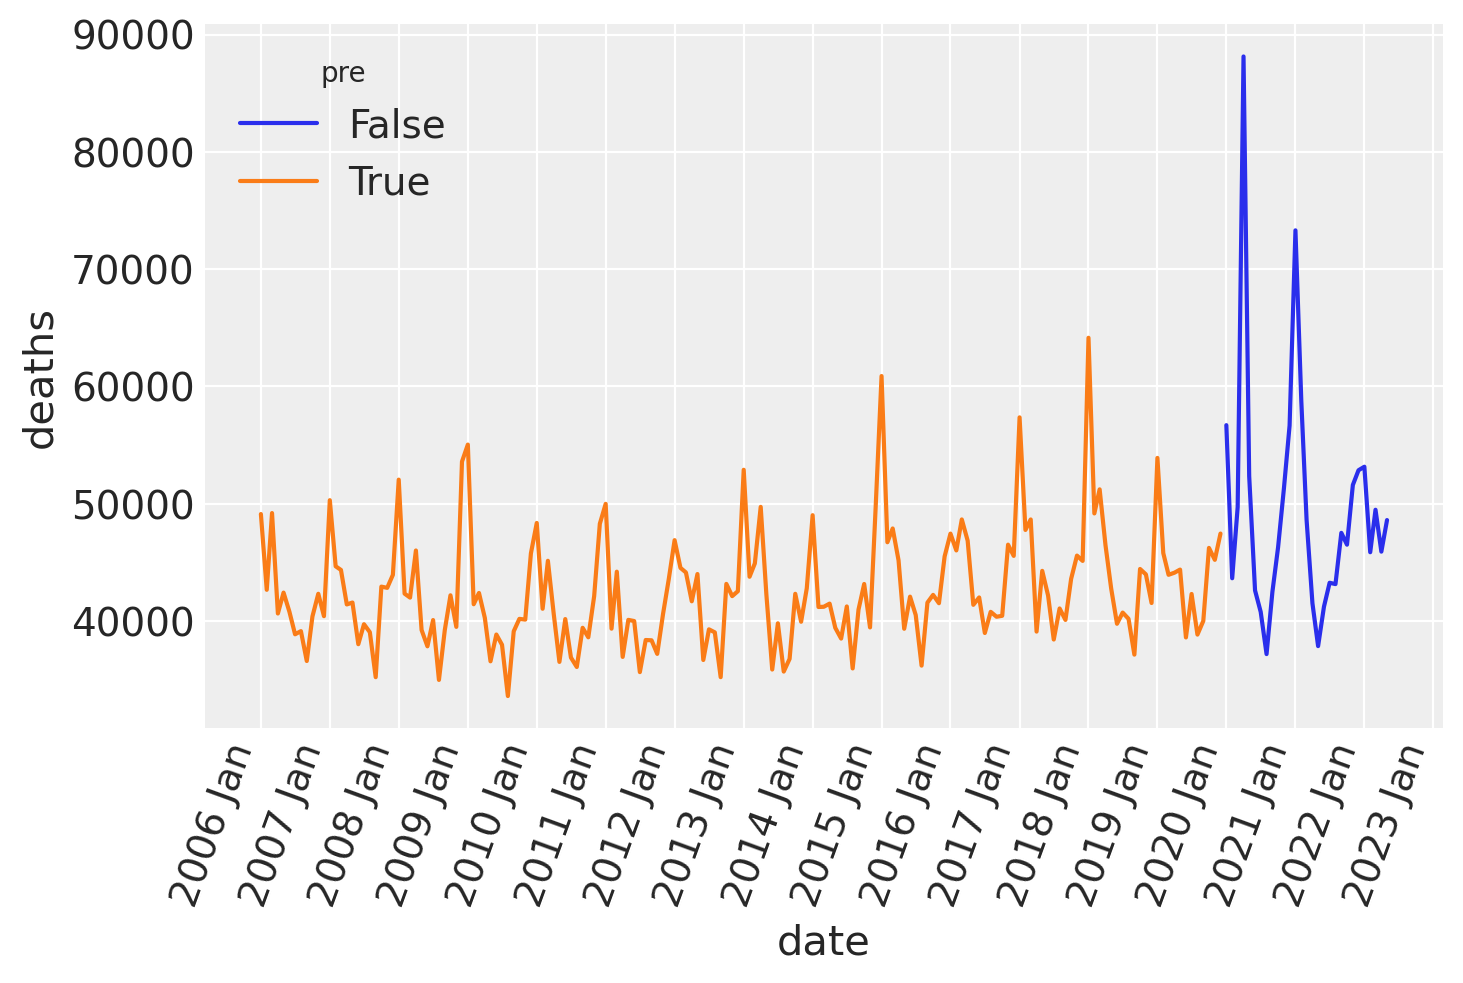

In [5]:
ax = sns.lineplot(data=df, x="date", y="deaths", hue="pre")
format_x_axis(ax)

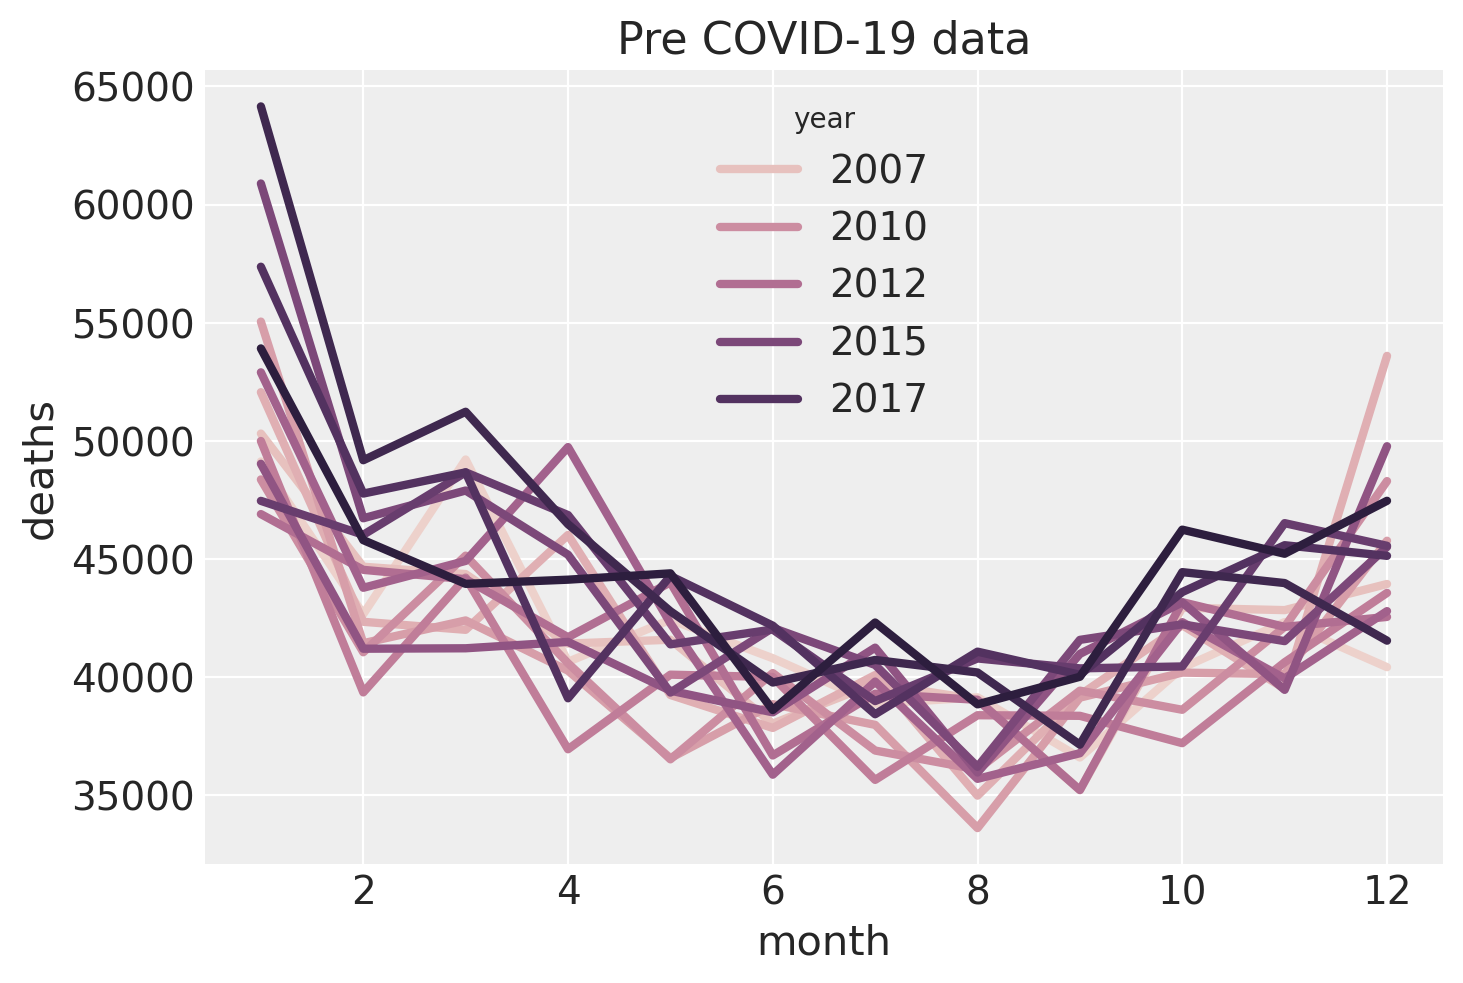

In [6]:
ax = sns.lineplot(data=pre, x="month", y="deaths", hue="year", lw=3)
ax.set(title="Pre COVID-19 data");

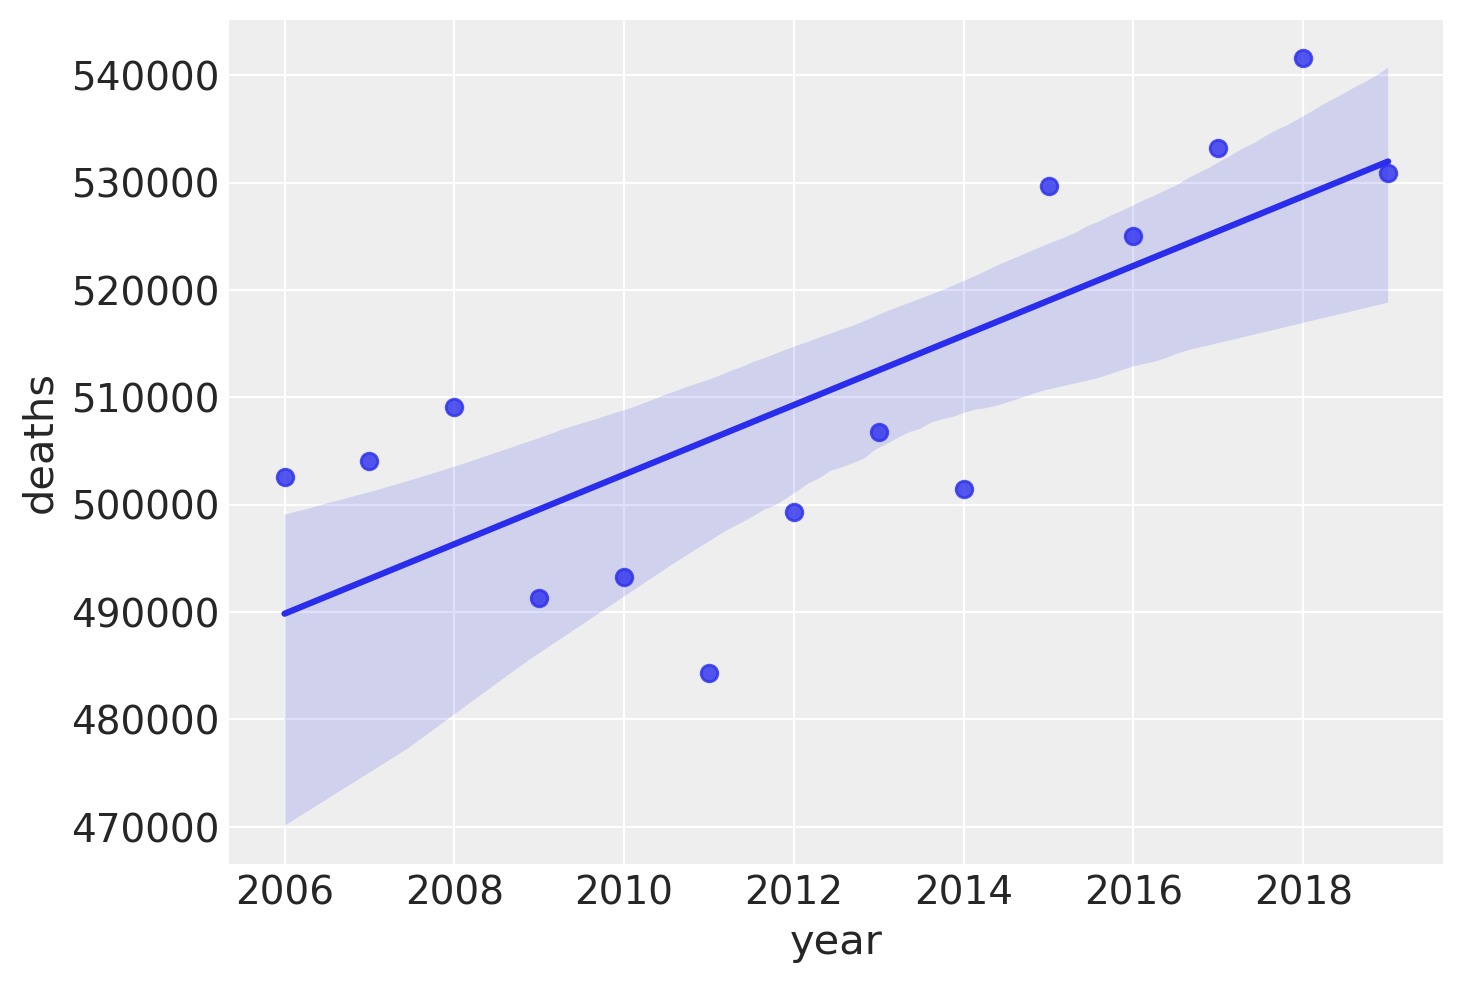

In [7]:
annual_deaths = pd.DataFrame(pre.groupby("year")["deaths"].sum()).reset_index()
sns.regplot(x="year", y="deaths", data=annual_deaths);

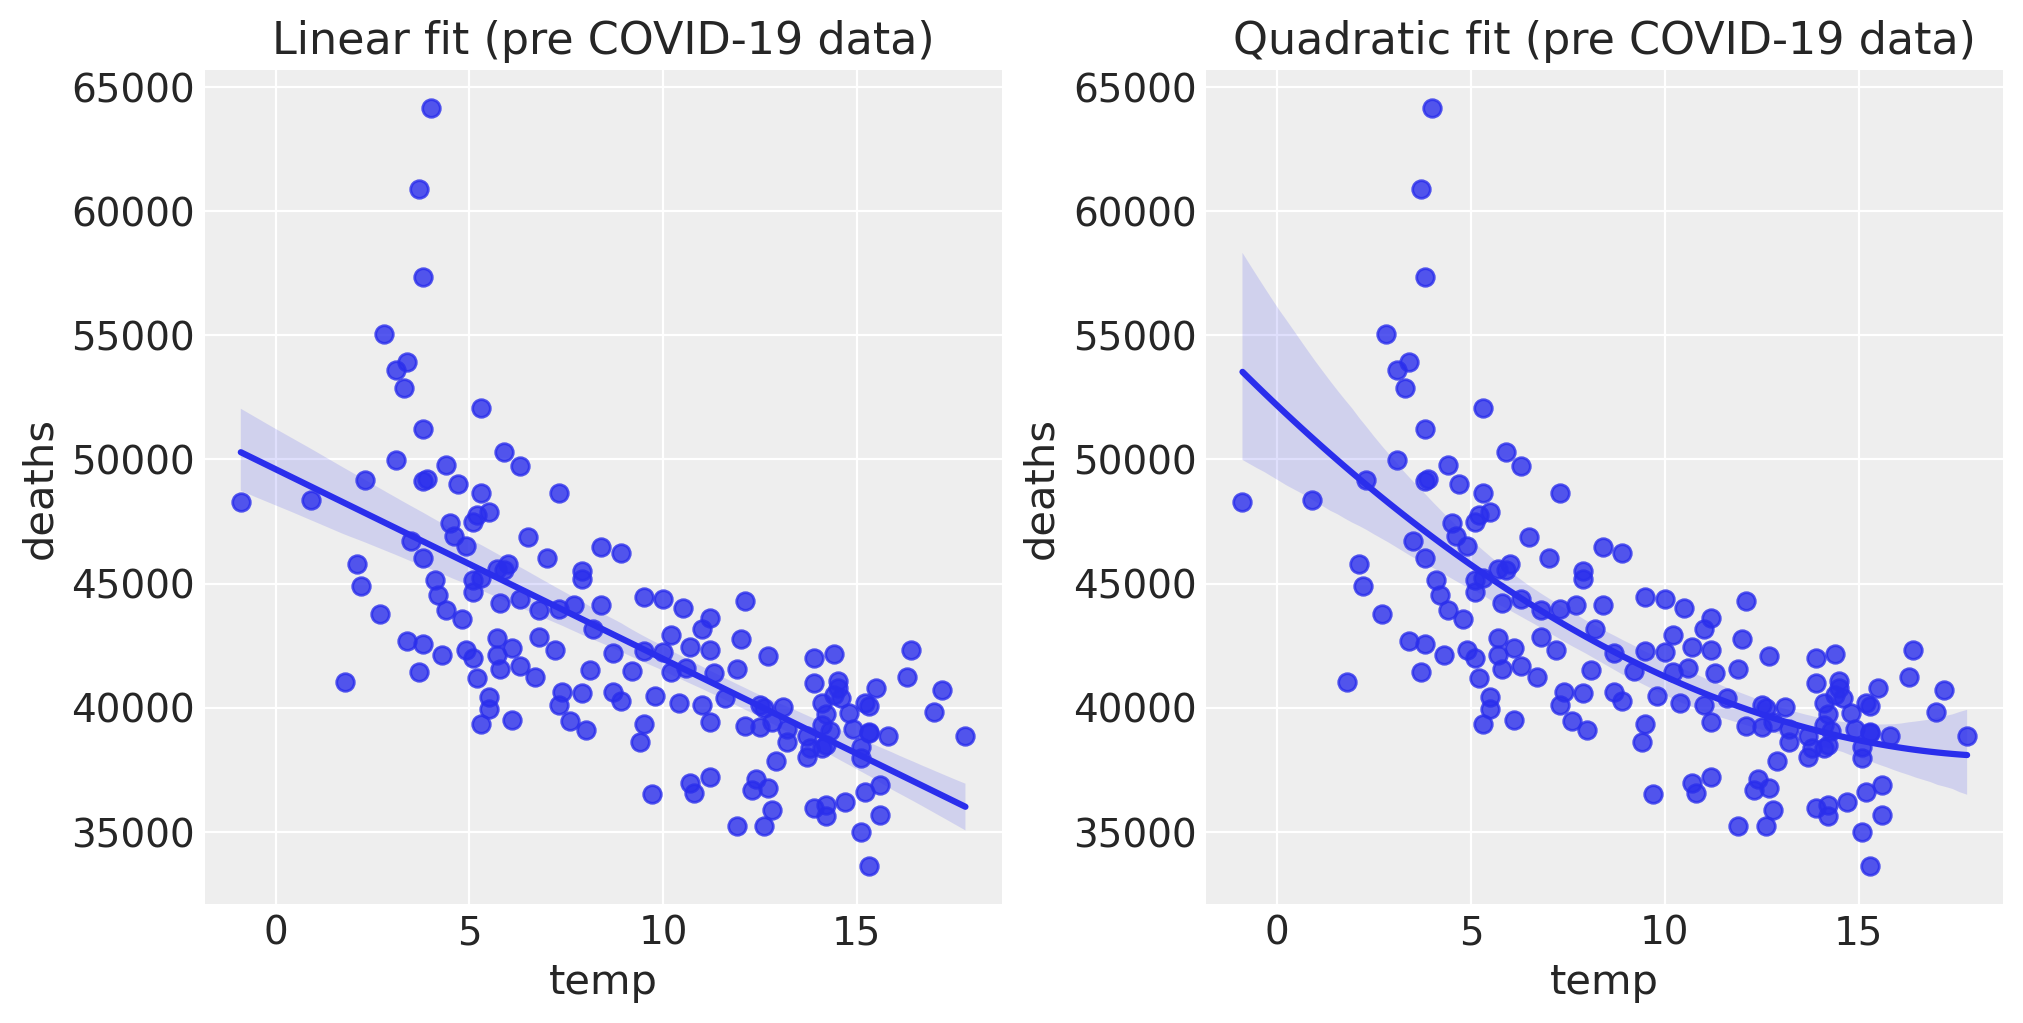

In [8]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=1, ax=ax[0])
ax[0].set(title="Linear fit (pre COVID-19 data)")
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=2, ax=ax[1])
ax[1].set(title="Quadratic fit (pre COVID-19 data)");

In [9]:
# NOTE: results are returned from higher to lower polynomial powers
slope, intercept = np.polyfit(pre["temp"], pre["deaths"], 1)
print(f"{slope:.0f} deaths/degree")

-764 deaths/degree


# Modeling

In [10]:
calendar.month_name[1:]

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [14]:
with pm.Model(coords={"month": month_strings}) as model:
    # observed predictors and outcome
    month = pm.Data("month", pre["month"].to_numpy(), dims="t")
    time = pm.Data("time", pre["t"].to_numpy(), dims="t")
    temp = pm.Data("temp", pre["temp"].to_numpy(), dims="t")
    deaths = pm.Data("deaths", pre["deaths"].to_numpy(), dims="t")

    # priors
    intercept = pm.Normal("intercept", 40_000, 10_000)
    month_mu = ZeroSumNormal("month mu", sigma=3000, dims="month")
    linear_trend = pm.TruncatedNormal("linear trend", 0, 50, lower=0)
    temp_coeff = pm.Normal("temp coeff", 0, 200)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) + month_mu[month - 1] + (temp_coeff * temp),
        dims="t",
    )
    sigma = pm.HalfNormal("sigma", 2_000)
    # likelihood
    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=deaths, dims="t")

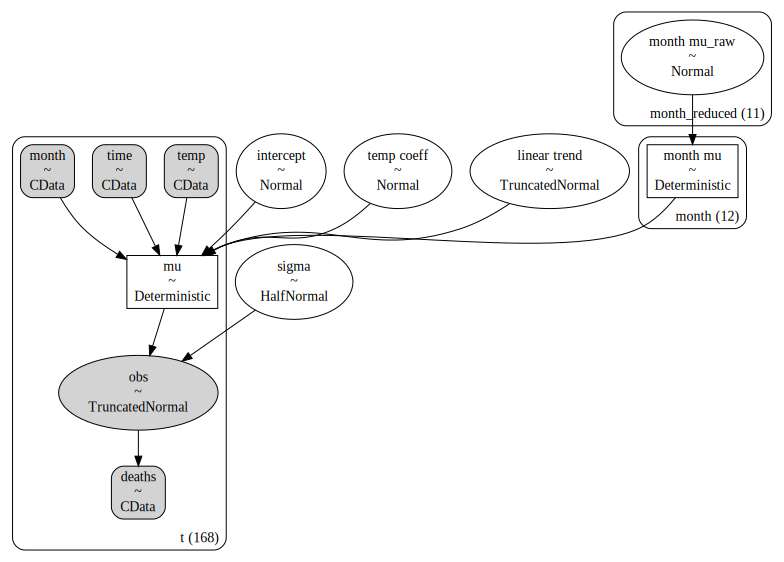

In [15]:
pm.model_to_graphviz(model)

## Prior Predictive Check

In [16]:
with model:
    idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [intercept, linear trend, month mu_raw, obs, sigma, temp coeff]


Sampling: [intercept, linear trend, month mu_raw, obs, sigma, temp coeff]


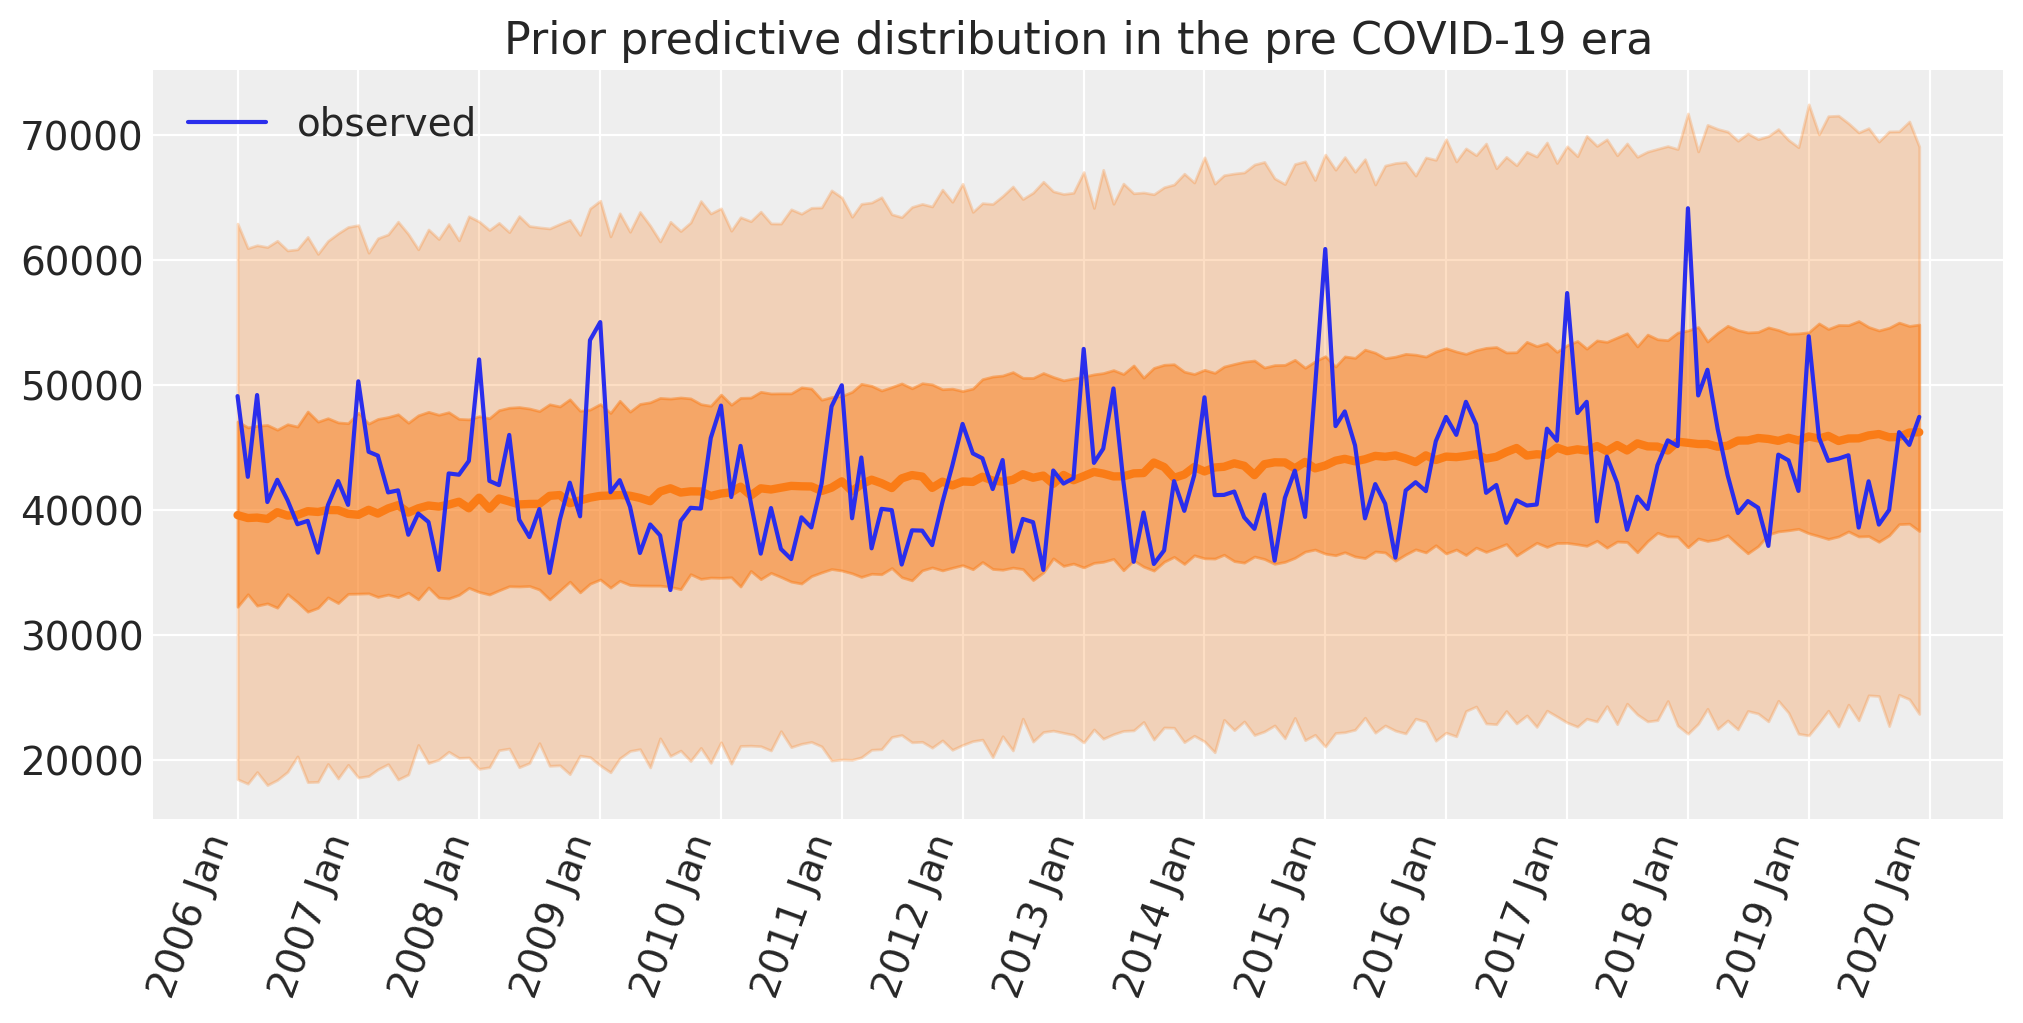

In [31]:
with model:
    idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(pre.index, pre["deaths"], label="observed")
ax.set(title="Prior predictive distribution in the pre COVID-19 era")
plt.legend()

<Axes: xlabel='obs'>

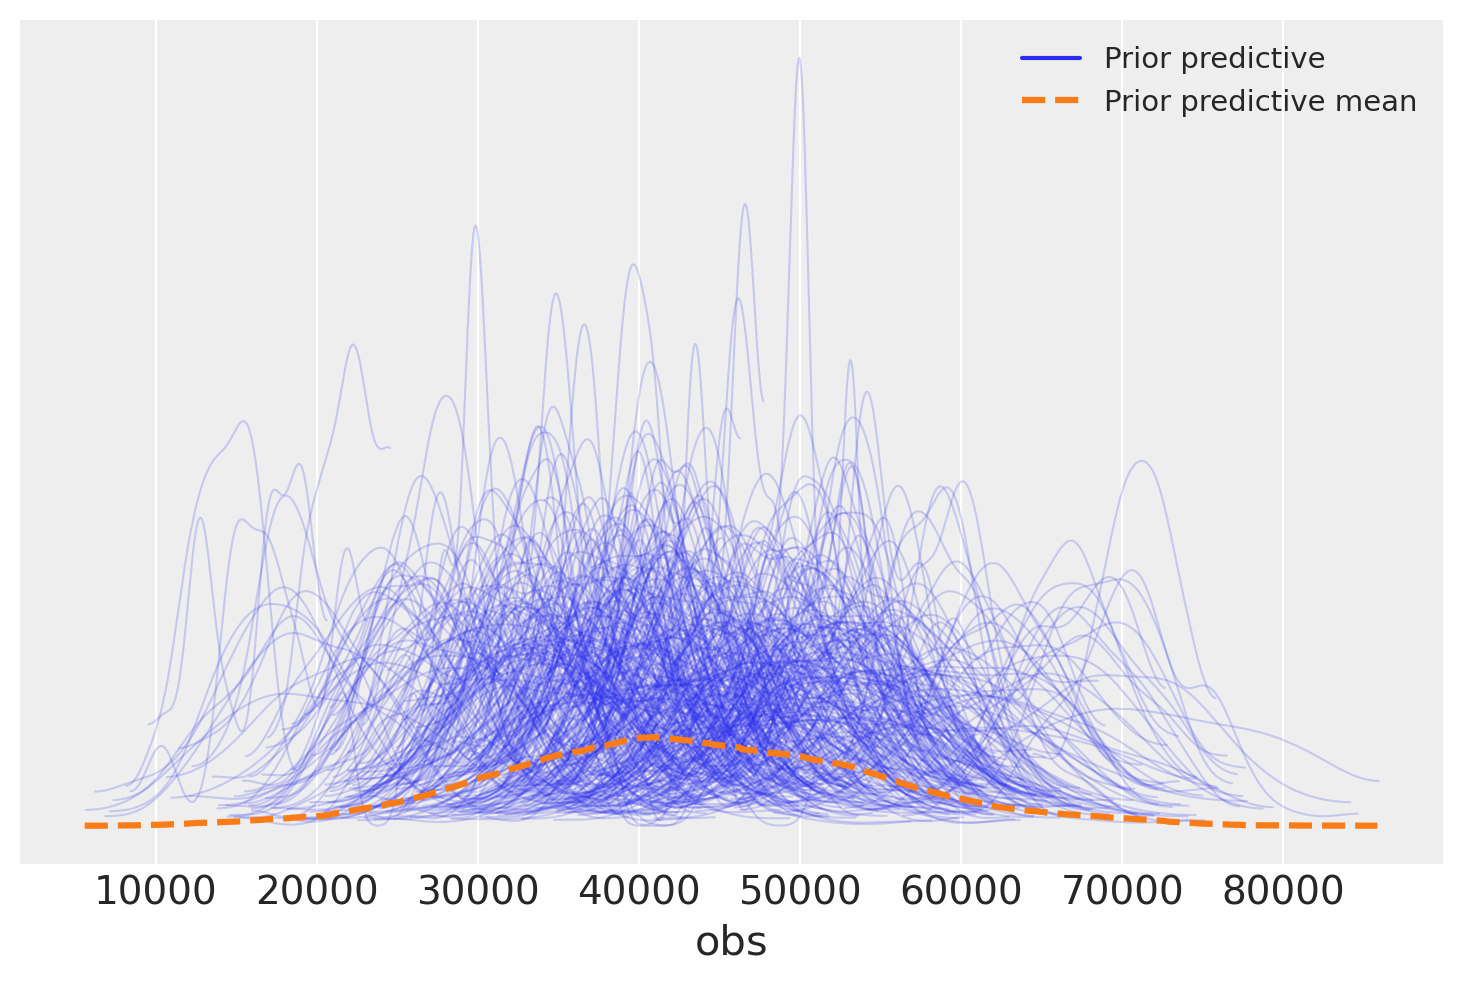

In [26]:
az.plot_ppc(idata, group="prior")

# Inference

In [32]:
with model:
    idata.extend(pm.sample(random_seed=RANDOM_SEED))

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


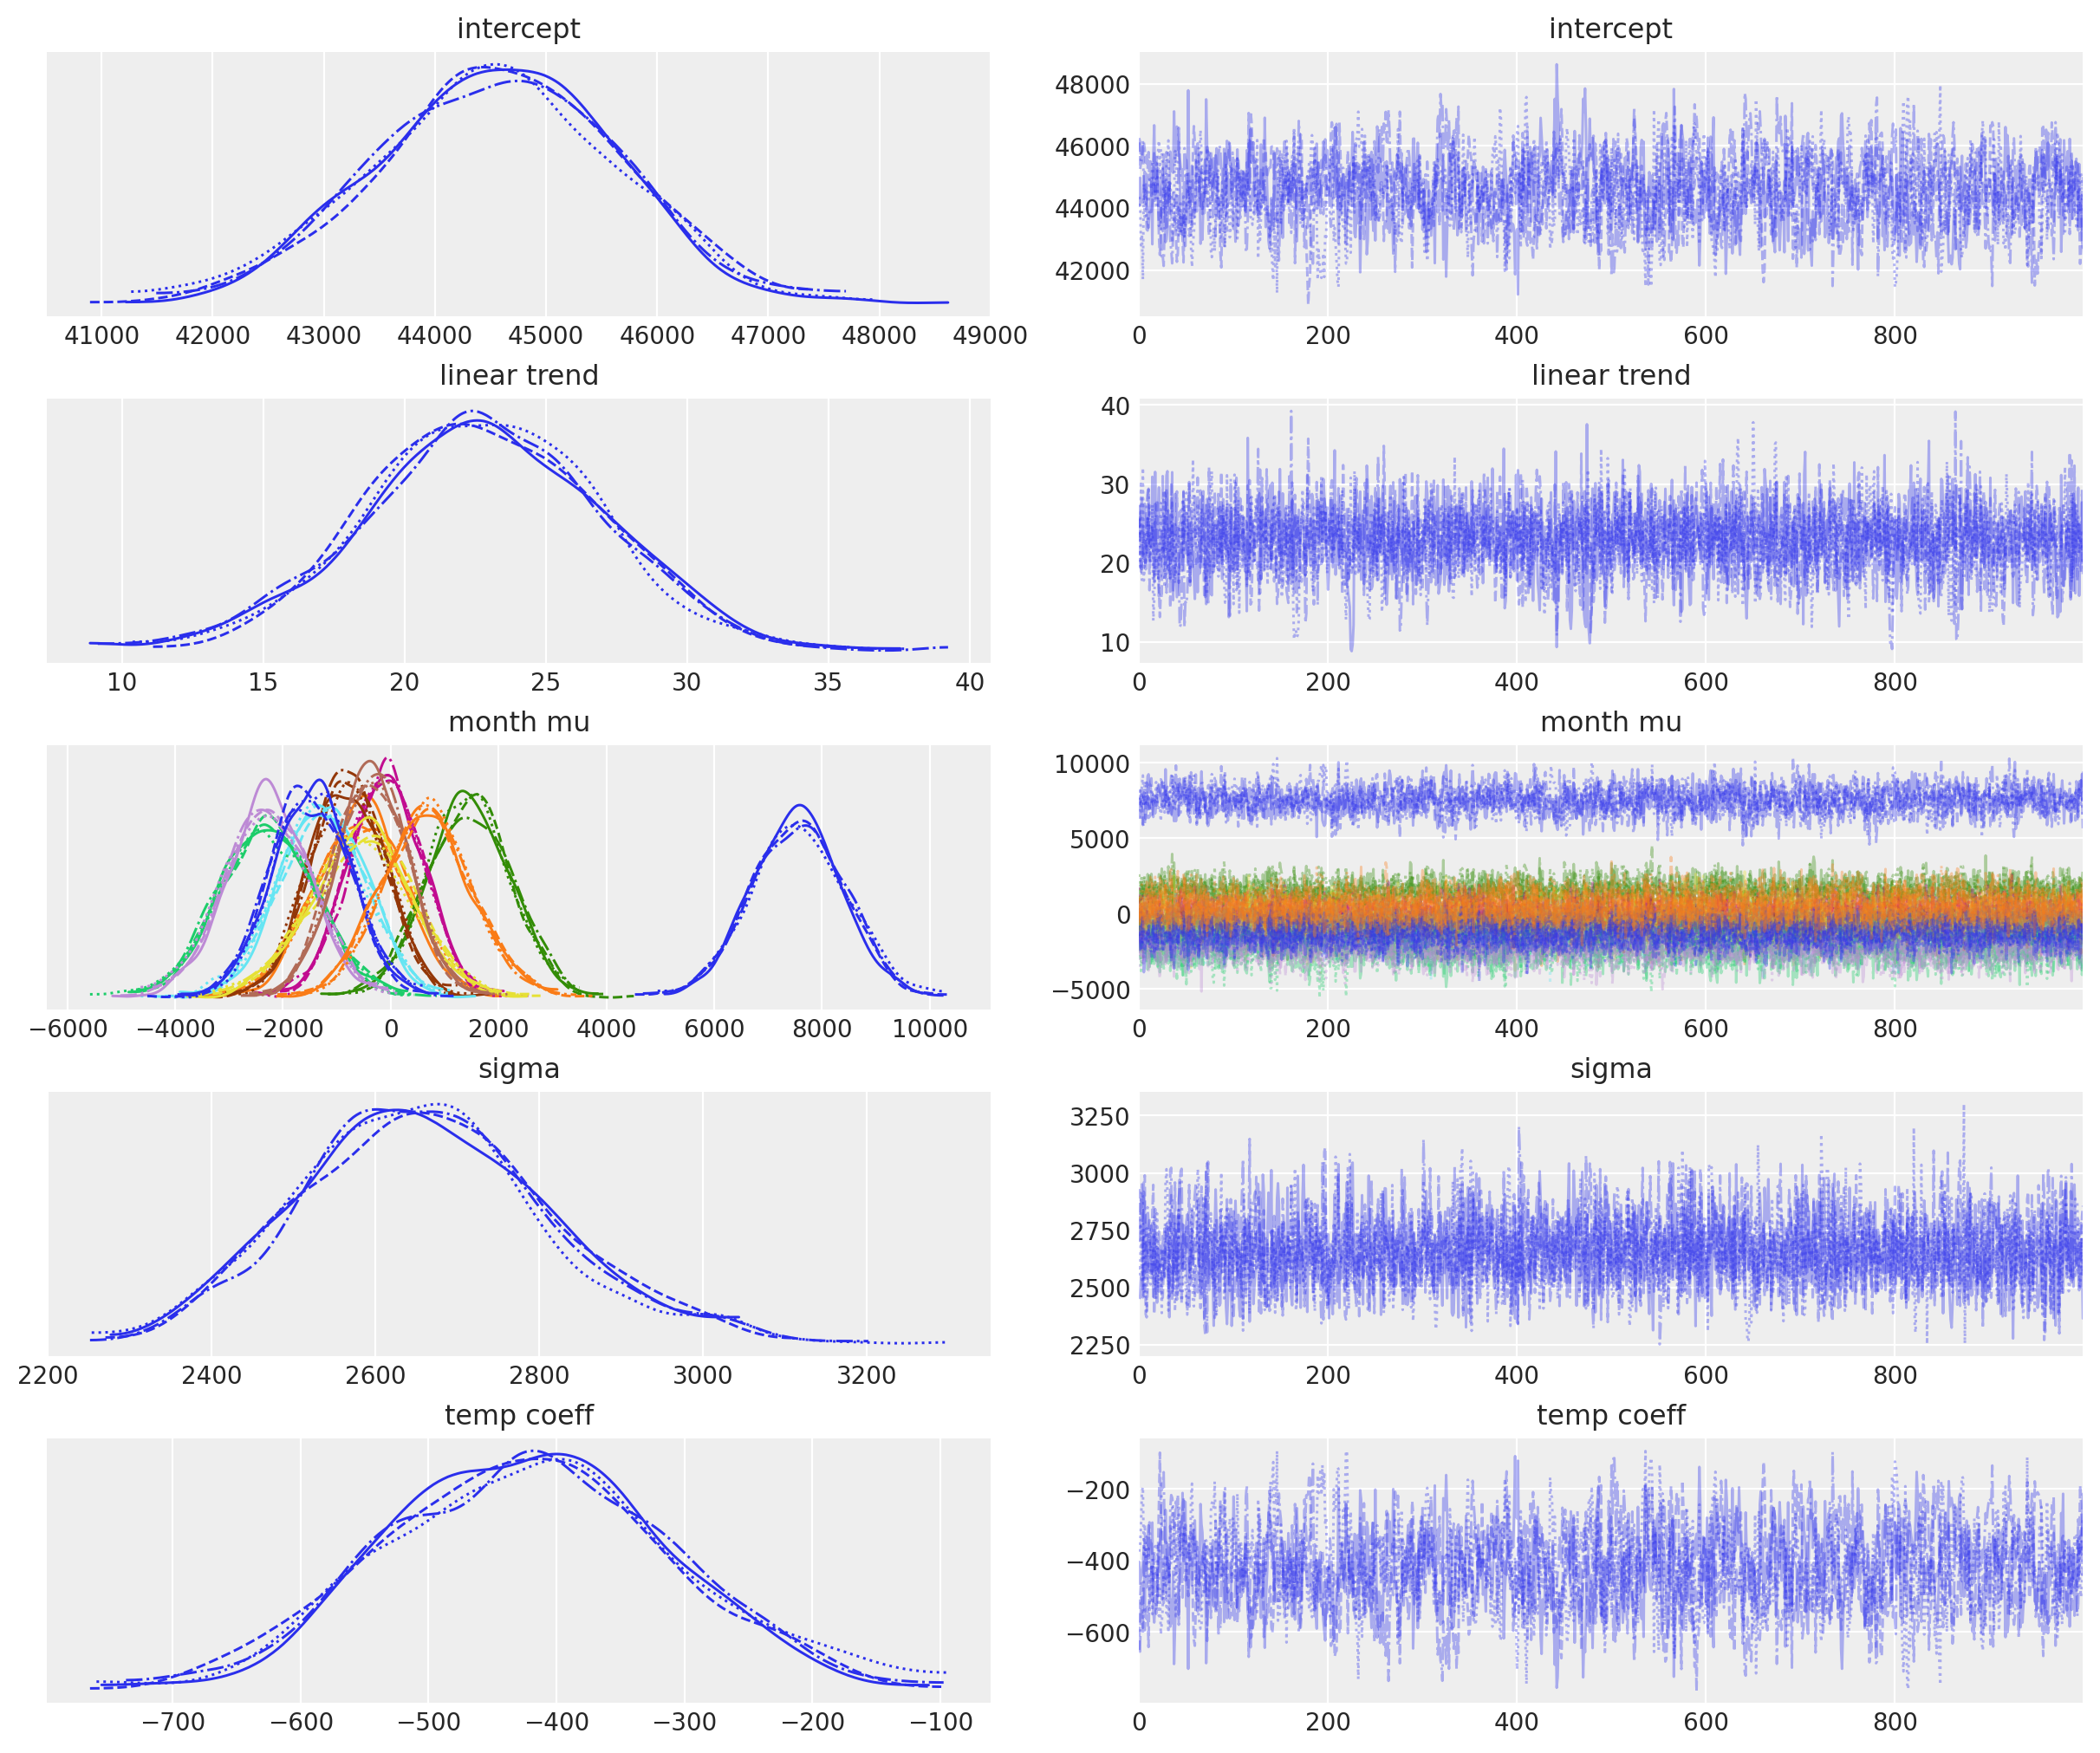

In [34]:
az.plot_trace(idata, var_names=["~mu", "~month mu_raw"])

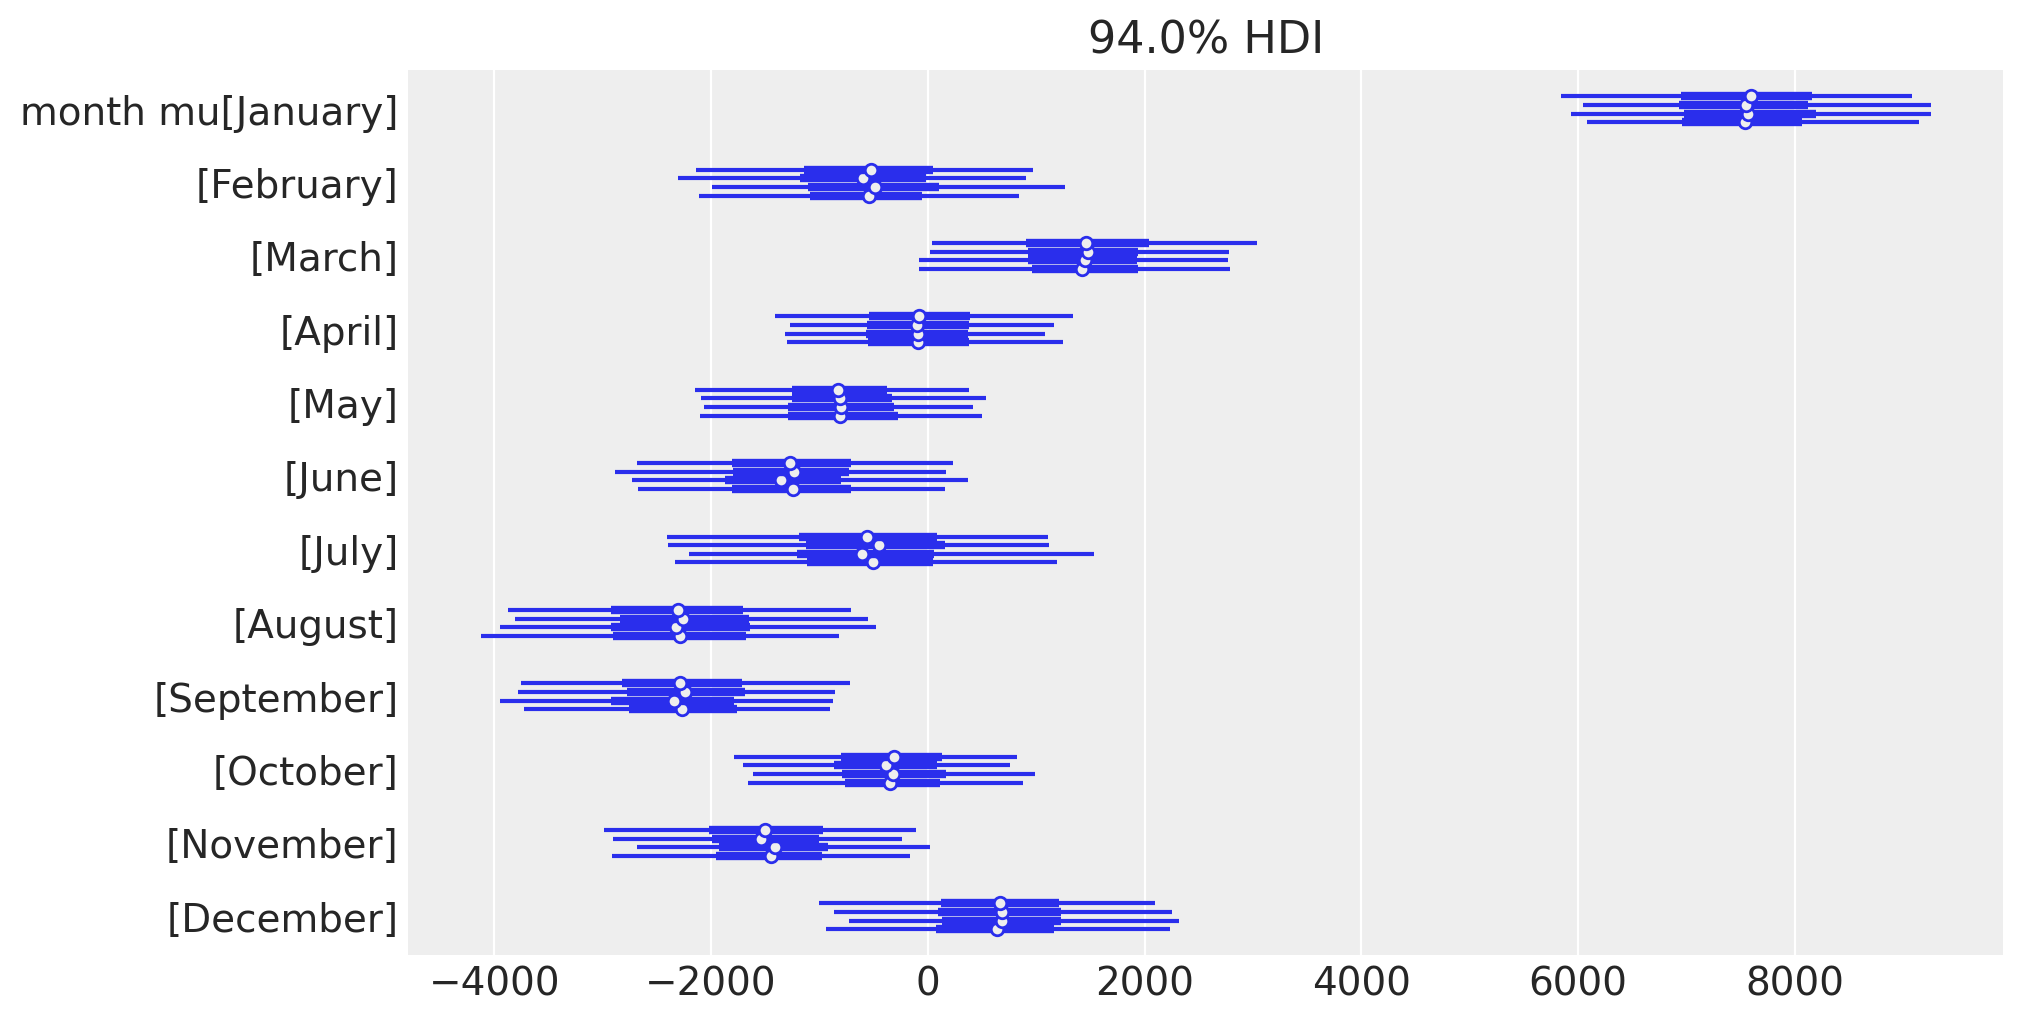

In [35]:
az.plot_forest(idata.posterior, var_names="month mu", figsize=figsize);

In [41]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))

Sampling: [month mu_raw, obs]


Output()

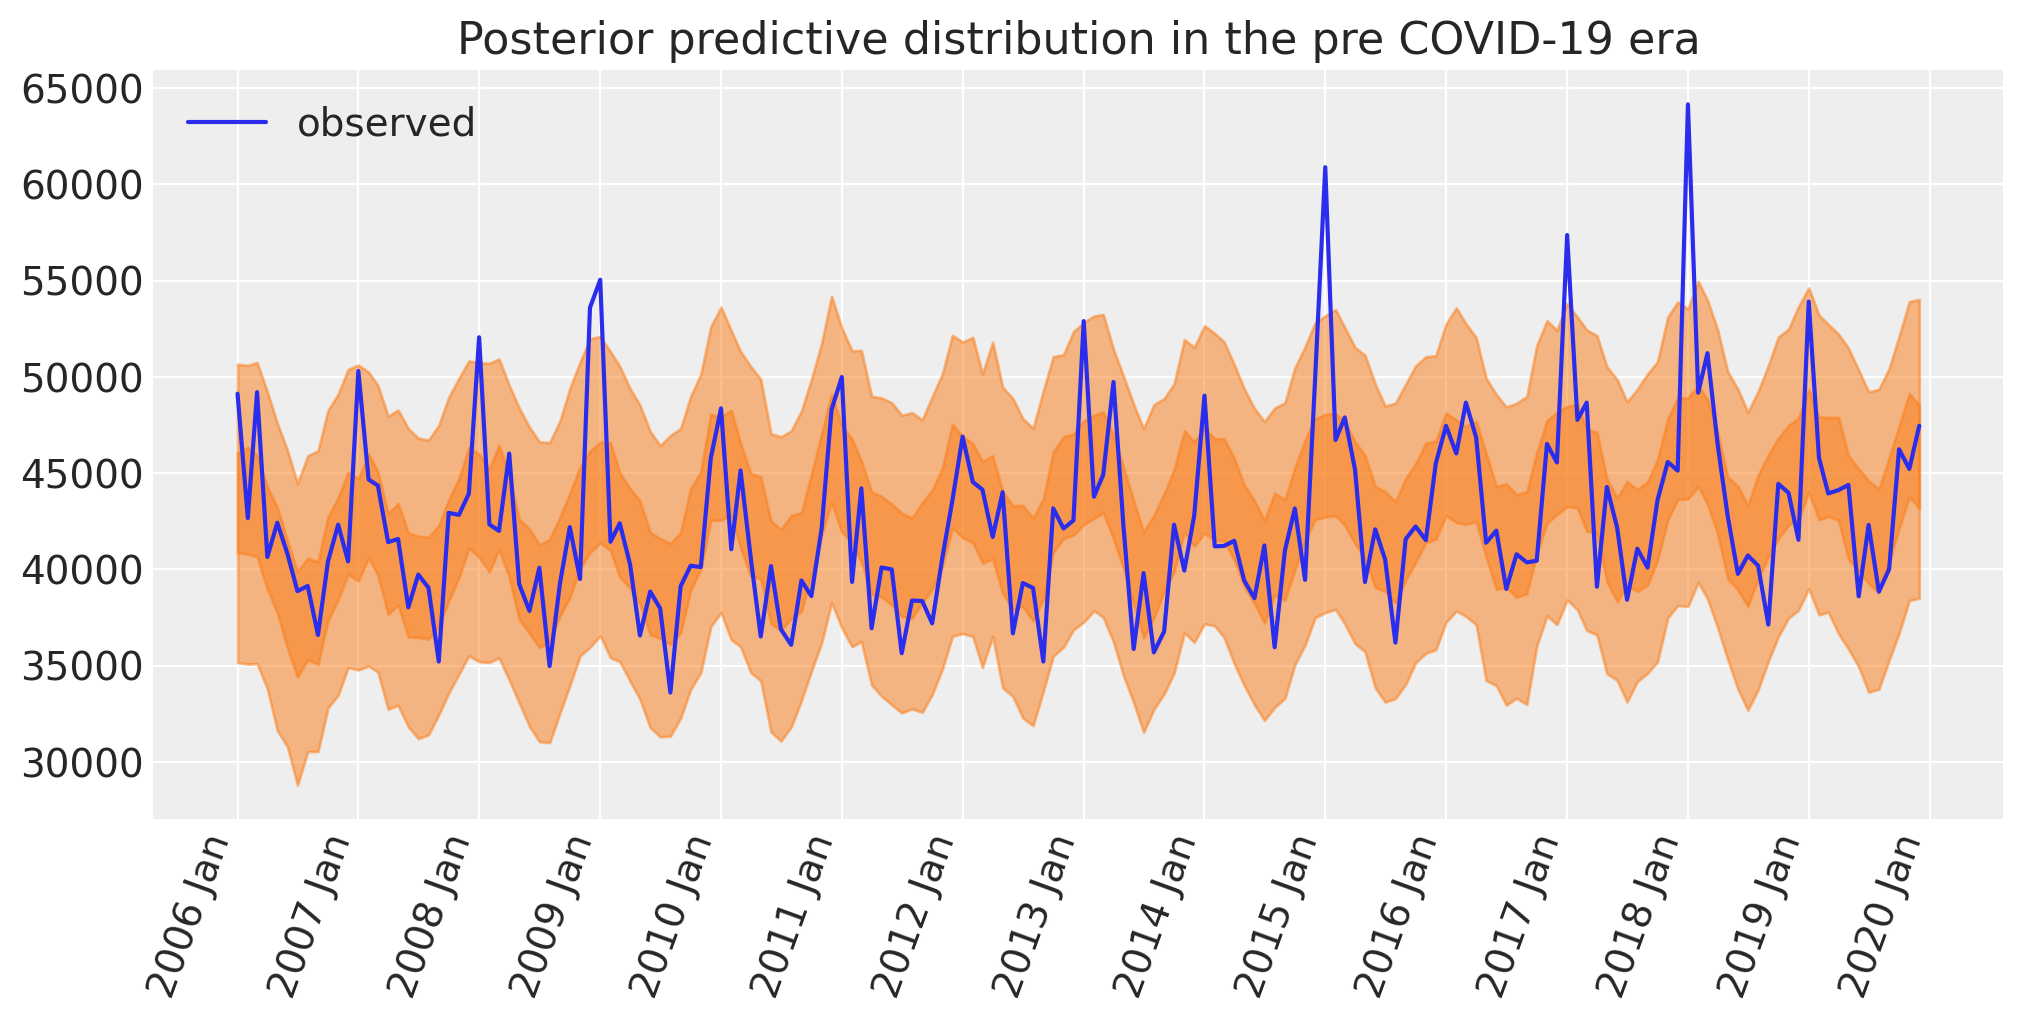

In [42]:
fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(pre.index, pre["deaths"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre COVID-19 era")
plt.legend()

In [51]:
temp

mu
t                
0    50494.307919
1    42577.733771
2    44396.547464
3    41404.588500
4    39325.676988
..            ...
163  39313.884467
164  40469.935326
165  44209.709646
166  44625.491110
167  46874.234216

[168 rows x 1 columns]

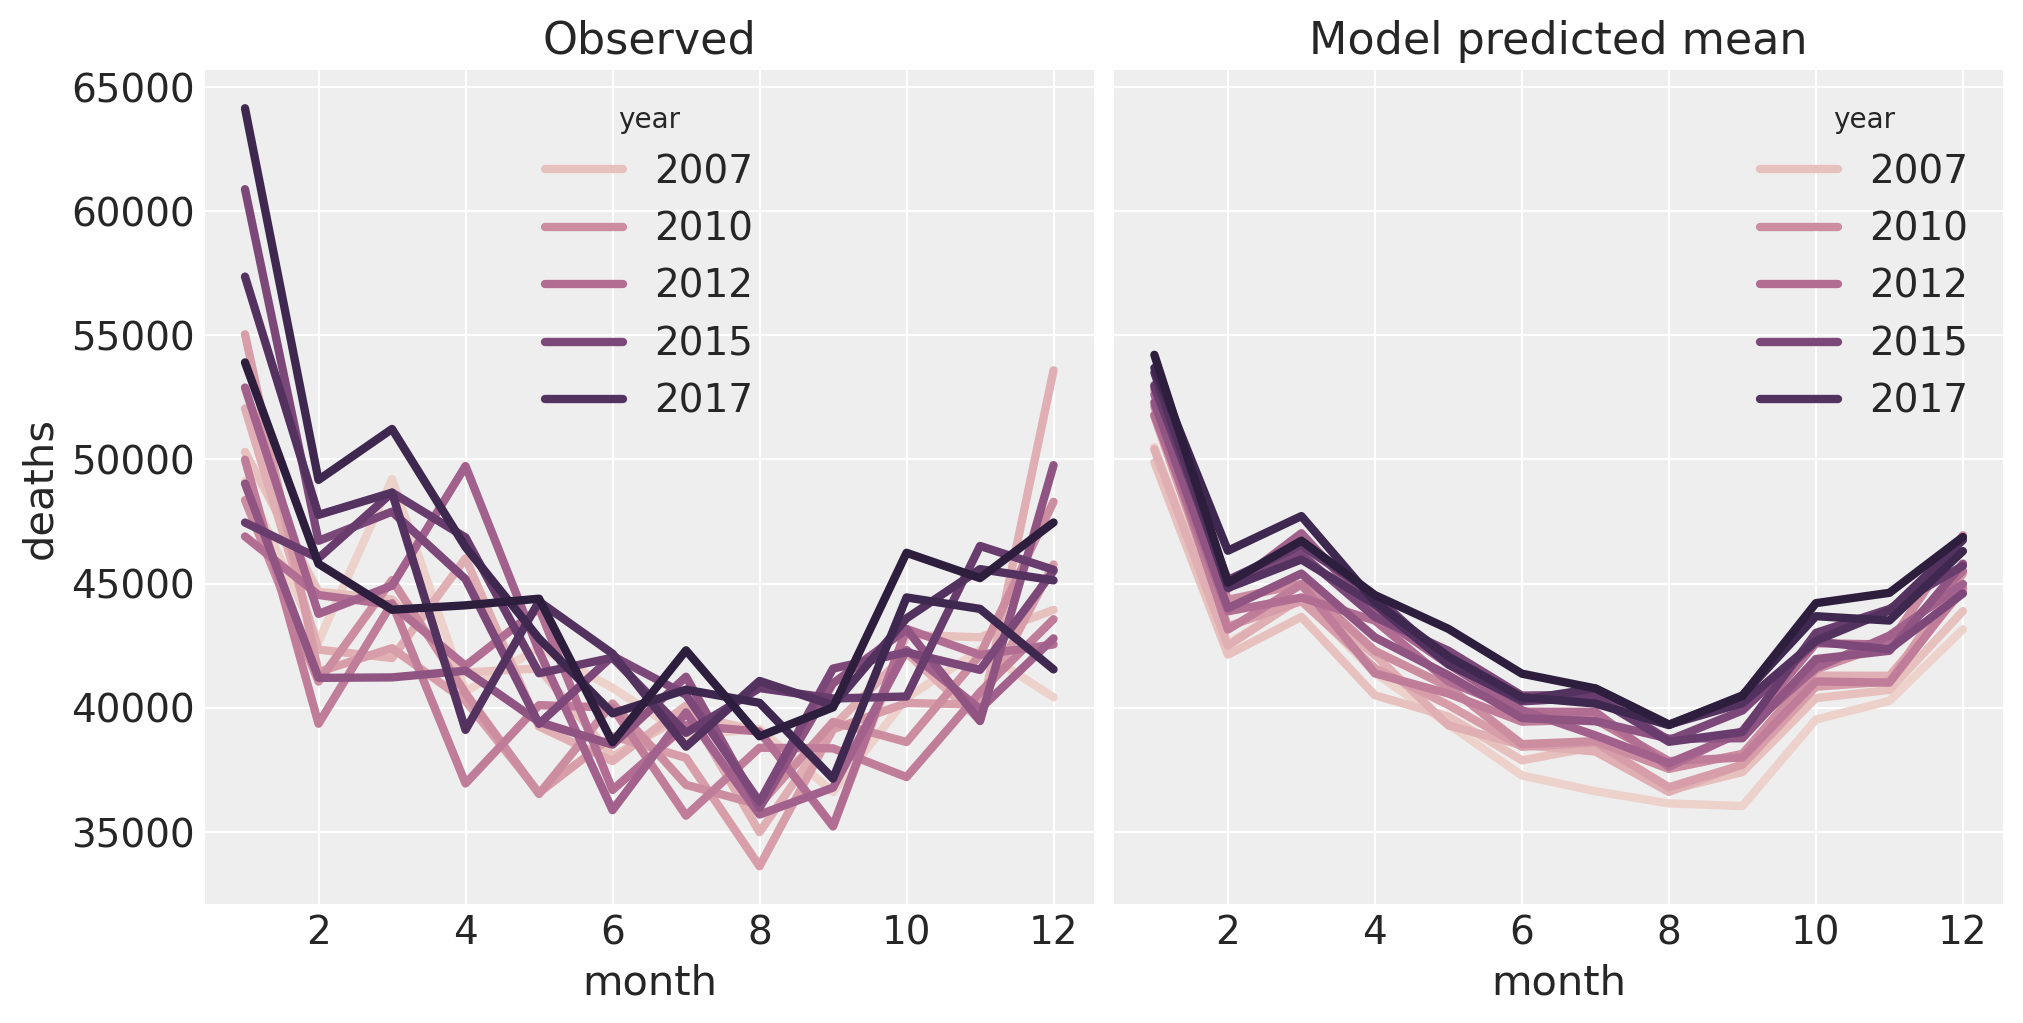

In [43]:
temp = idata.posterior["mu"].mean(dim=["chain", "draw"]).to_dataframe()
pre = pre.assign(deaths_predicted=temp["mu"].values)

fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)
sns.lineplot(data=pre, x="month", y="deaths", hue="year", ax=ax[0], lw=3)
ax[0].set(title="Observed")
sns.lineplot(data=pre, x="month", y="deaths_predicted", hue="year", ax=ax[1], lw=3)
ax[1].set(title="Model predicted mean")

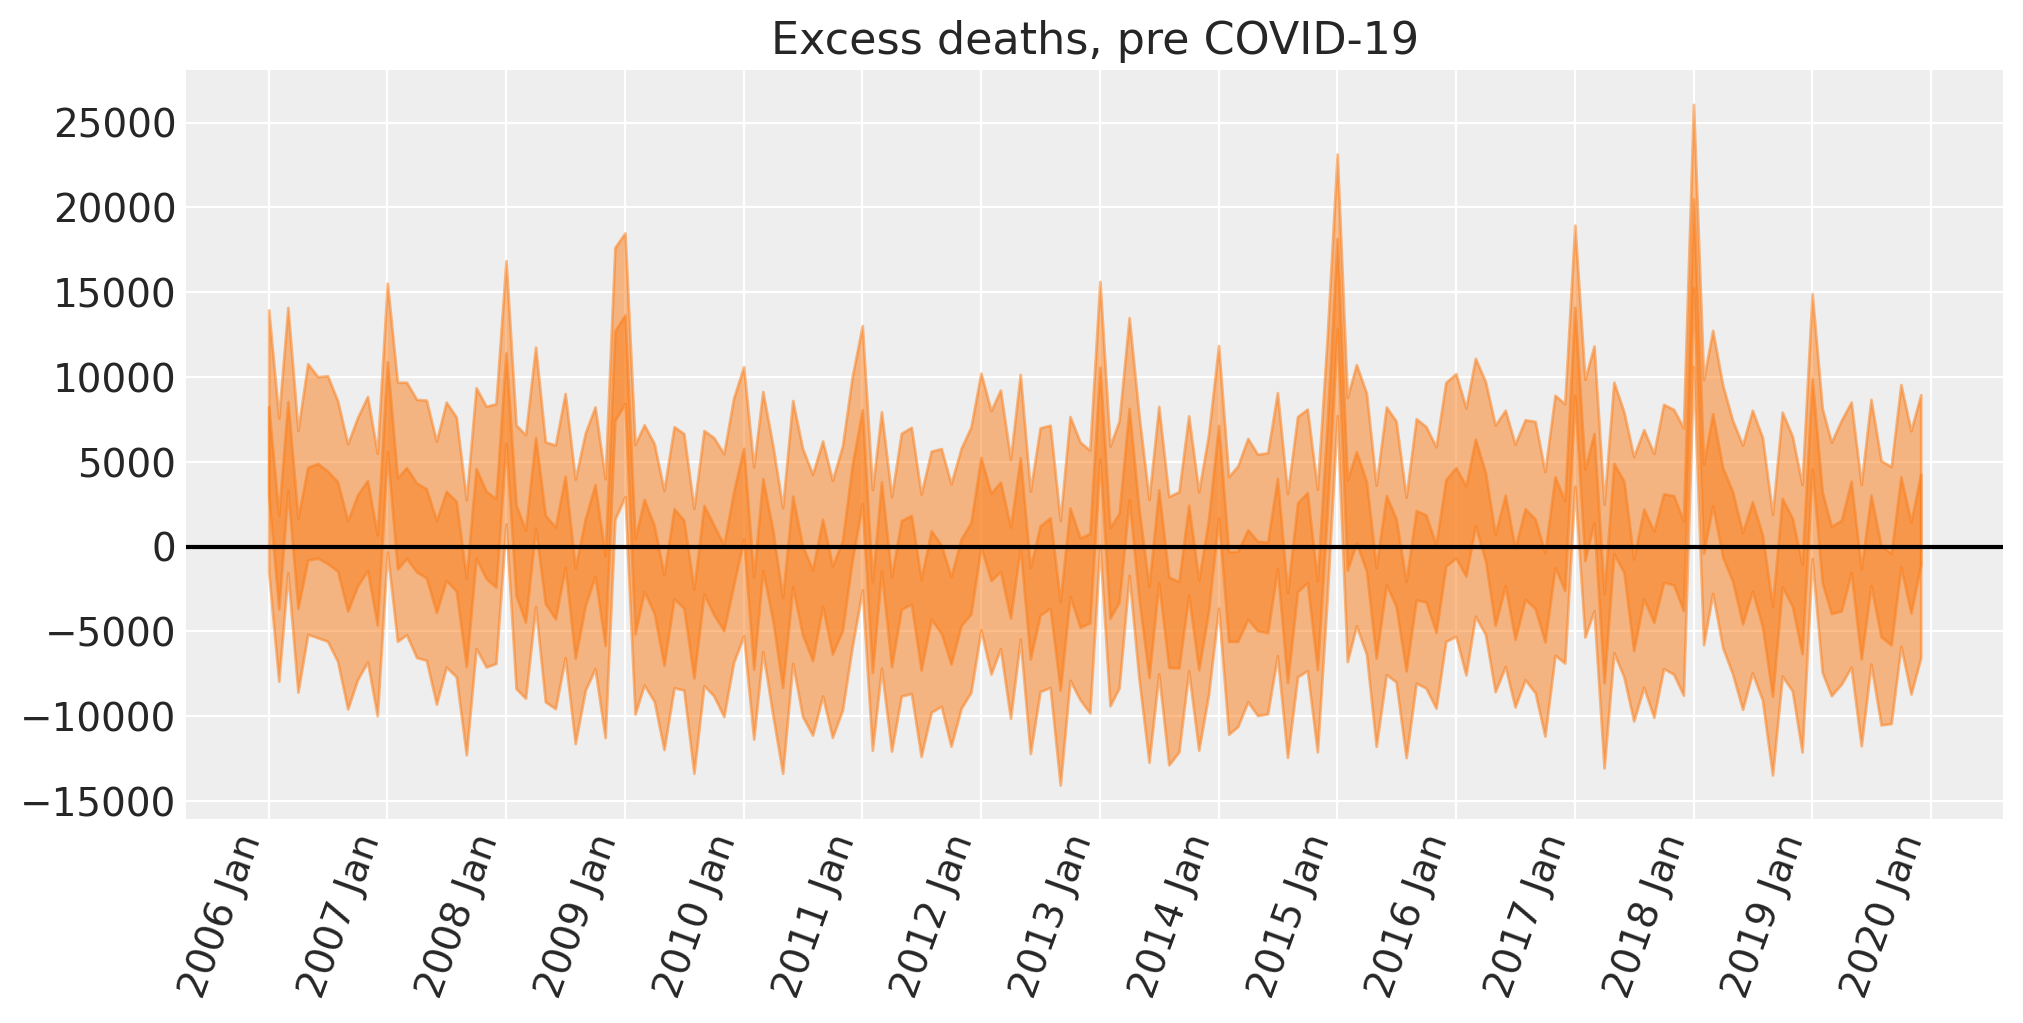

In [52]:
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(pre["deaths"].to_numpy(), dims=["t"])

# do the calculation by taking the difference
excess_deaths = deaths - idata.posterior_predictive["obs"] #posterior_predictive에서 sampling한 값

fig, ax = plt.subplots(figsize=figsize)
# the transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
az.plot_hdi(pre.index, excess_deaths.transpose(..., "t"), hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, excess_deaths.transpose(..., "t"), hdi_prob=0.95, smooth=False)
format_x_axis(ax)
ax.axhline(y=0, color="k")
ax.set(title="Excess deaths, pre COVID-19")

In [54]:
with model:
    pm.set_data(
        {
            "month": post["month"].to_numpy(),
            "time": post["t"].to_numpy(),
            "temp": post["temp"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=RANDOM_SEED
    )

Sampling: [month mu_raw, obs]


Output()

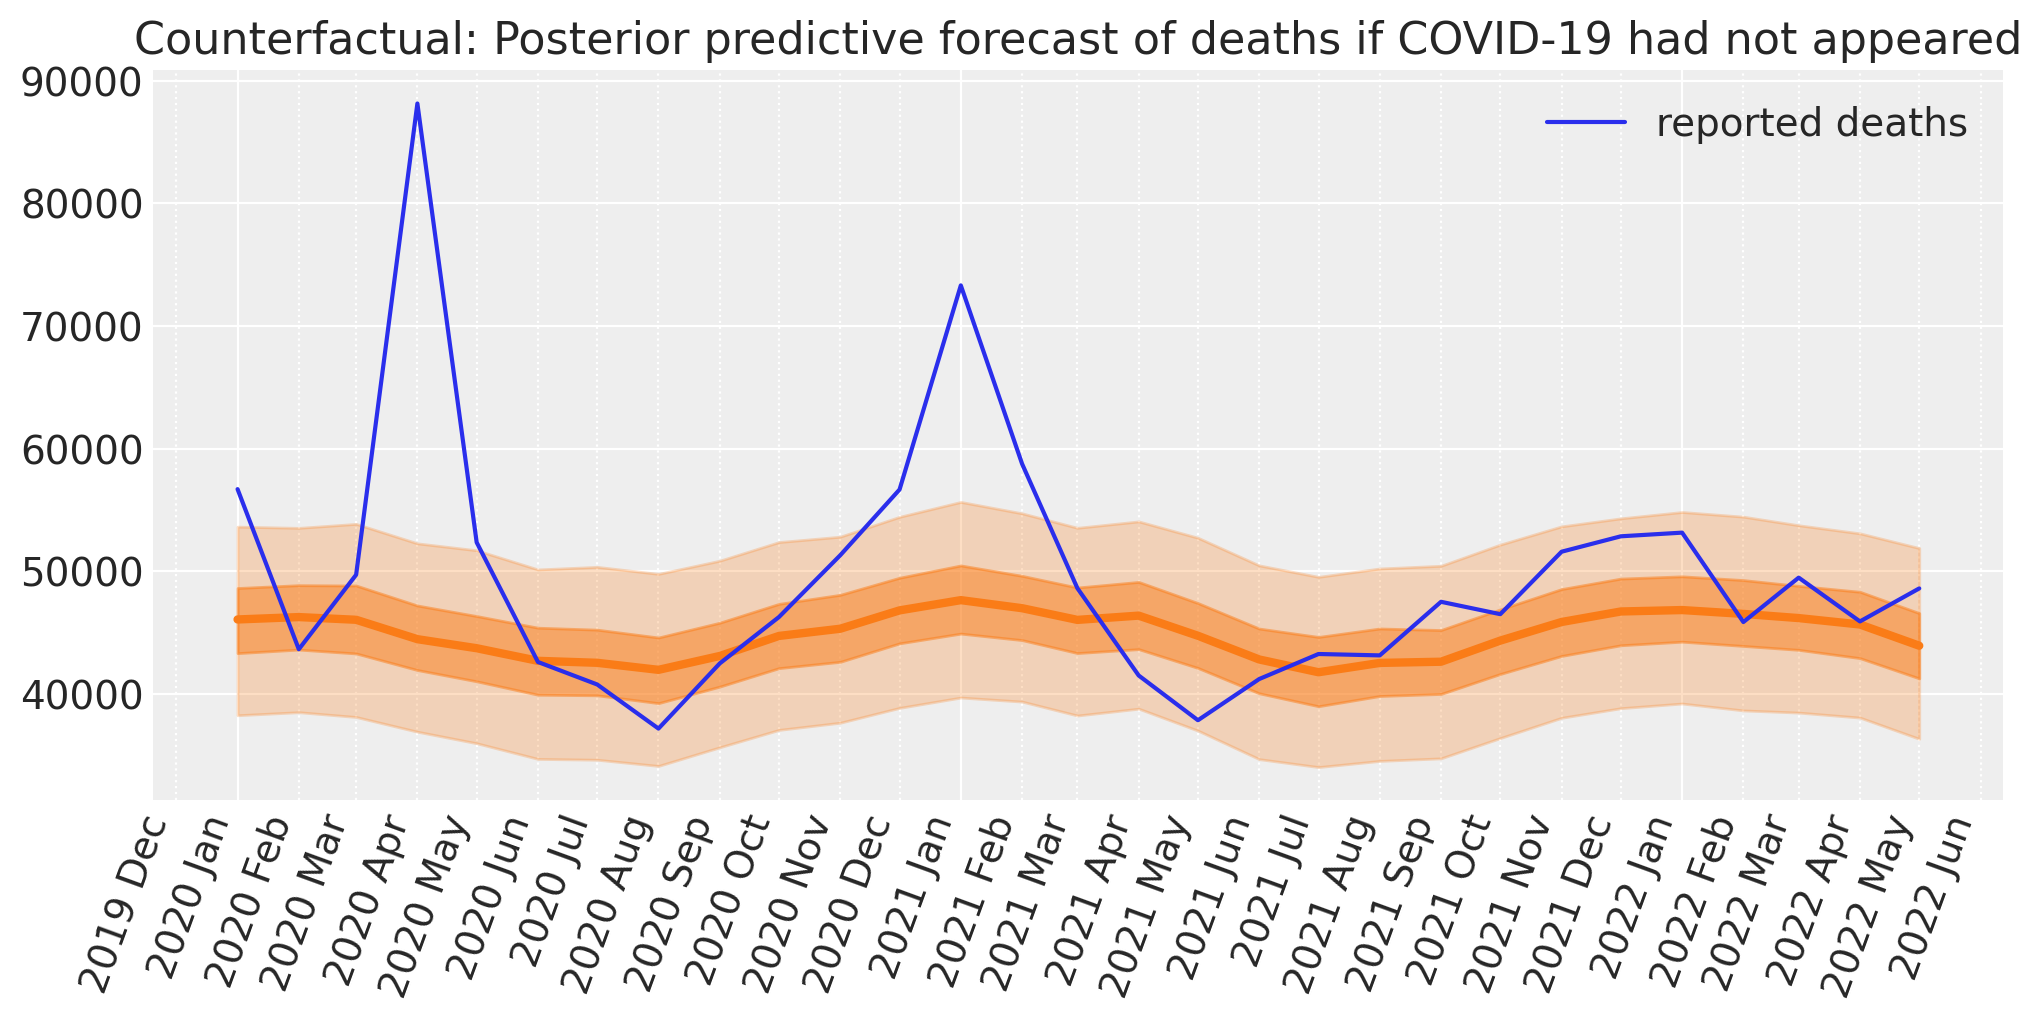

In [55]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=True)
ax.plot(post.index, post["deaths"], label="reported deaths")
ax.set(title="Counterfactual: Posterior predictive forecast of deaths if COVID-19 had not appeared")
plt.legend()

In [58]:
counterfactual.posterior_predictive["obs"]

<xarray.DataArray 'obs' (chain: 4, draw: 1000, t: 29)> Size: 928kB
array([[[44720.46296899, 50673.44563804, 48992.55932492, ...,
         50769.59639938, 41286.29614543, 47742.58292284],
        [50298.39611744, 41368.97024079, 48780.86159604, ...,
         51838.0602167 , 43385.10178367, 43844.97174104],
        [47486.4165413 , 46316.9990196 , 45303.11035875, ...,
         50243.46895098, 49657.70734775, 42942.76372308],
        ...,
        [49432.04575345, 44021.1381898 , 47493.14301547, ...,
         47821.97522765, 49114.8122776 , 43254.69123207],
        [38859.62278076, 47346.90210152, 45548.13009004, ...,
         47260.60125007, 48886.29983635, 37144.72693265],
        [39122.32775406, 38330.01569643, 42968.7570341 , ...,
         50435.819512  , 46456.24443365, 44915.56069181]],

       [[48518.76425175, 44923.8179969 , 46909.05285974, ...,
         43917.9533668 , 39664.53414676, 39637.0866017 ],
        [47848.54907135, 45935.17017456, 37680.60723688, ...,
         41356.67543317, 45162.20252273, 44700.7996321 ],
        [45450.43315755, 46304.68549601, 48718.03166117, ...,
         46327.92437332, 45173.1356821 , 46838.49794454],
...
        [47464.19898963, 45728.61405813, 41327.13942135, ...,
         42622.53471453, 40515.93679594, 47198.86972053],
        [45999.4549195 , 33656.62649461, 49201.81555547, ...,
         51819.66990051, 52078.59416382, 42872.83952858],
        [49017.07930563, 45567.79870381, 45033.05286134, ...,
         41004.84254104, 47992.47822653, 39661.6680922 ]],

       [[43140.82863707, 46894.59376267, 48975.32857929, ...,
         47584.07246364, 52500.13954428, 44136.1034016 ],
        [43770.50928955, 51859.17121597, 44988.30495484, ...,
         45059.89748634, 43291.90266178, 45072.66090157],
        [48307.15962366, 46378.14119121, 44618.87701715, ...,
         46079.0790395 , 48102.73969967, 43573.87925813],
        ...,
        [47477.35011883, 47828.21559015, 47830.05894202, ...,
         46152.84214288, 39405.88102043, 47537.16349754],
        [46737.85020862, 48210.11660674, 41829.88980826, ...,
         39340.27924782, 40650.01963633, 46496.83202458],
        [45709.97019795, 54203.58909875, 43768.45706343, ...,
         49795.45875009, 41354.58590187, 42586.44812129]]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * t        (t) int64 232B 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28

In [59]:
excess_deaths

<xarray.DataArray (t: 29, chain: 4, draw: 1000)> Size: 928kB
array([[[ 11983.53703101,   6405.60388256,   9217.5834587 , ...,
           7271.95424655,  17844.37721924,  17581.67224594],
        [  8185.23574825,   8855.45092865,  11253.56684245, ...,
           8640.53484753,  12624.98071502,  11145.40719776],
        [ 12804.16716491,   7803.49091624,  13307.72872856, ...,
           9239.80101037,  10704.5450805 ,   7686.92069437],
        [ 13563.17136293,  12933.49071045,   8396.84037634, ...,
           9226.64988117,   9966.14979138,  10994.02980205]],

       [[ -7023.44563804,   2281.02975921,  -2666.9990196 , ...,
           -371.1381898 ,  -3696.90210152,   5319.98430357],
        [ -1273.8179969 ,  -2285.17017456,  -2654.68549601, ...,
         -10272.11568437,    934.68252174,   -603.56947249],
        [ -1340.9318152 ,  -7476.49094209,  -2471.45547652, ...,
          -2078.61405813,   9993.37350539,  -1917.79870381],
        [ -3244.59376267,  -8209.17121597,  -2728.14119121, ...,
          -4178.21559015,  -4560.11660674, -10553.58909875]],

       [[   730.44067508,    942.13840396,   4419.88964125, ...,
           2229.85698453,   4174.86990996,   6754.2429659 ],
...
        [  1904.92753636,   4429.10251366,   3409.9209605 , ...,
           3336.15785712,  10148.72075218,   -306.45875009]],

       [[  4632.70385457,   2533.89821633,  -3738.70734775, ...,
          -3195.8122776 ,  -2967.29983635,   -537.24443365],
        [  6254.46585324,    756.79747727,    745.8643179 , ...,
          -1240.02645815,   1858.34944291,   4841.2824666 ],
        [ -2641.56266216,  -4028.8638476 ,  11084.55790345, ...,
           5403.06320406,  -6159.59416382,  -2073.47822653],
        [ -6581.13954428,   2627.09733822,  -2183.73969967, ...,
           6513.11897957,   5268.98036367,   4564.41409813]],

       [[   868.41707716,   4766.02825896,   5668.23627692, ...,
           5356.30876793,  11466.27306735,   3695.43930819],
        [  8973.9133983 ,   3910.2003679 ,   1772.50205546, ...,
           4060.58639723,   6408.79883917,  11819.41283442],
        [  4247.06841133,   8305.11303738,  -1406.74324896, ...,
           1412.13027947,   5738.16047142,   8949.3319078 ],
        [  4474.8965984 ,   3538.33909843,   5037.12074187, ...,
           1073.83650246,   2114.16797542,   6024.55187871]]])
Coordinates:
  * t        (t) int64 232B 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

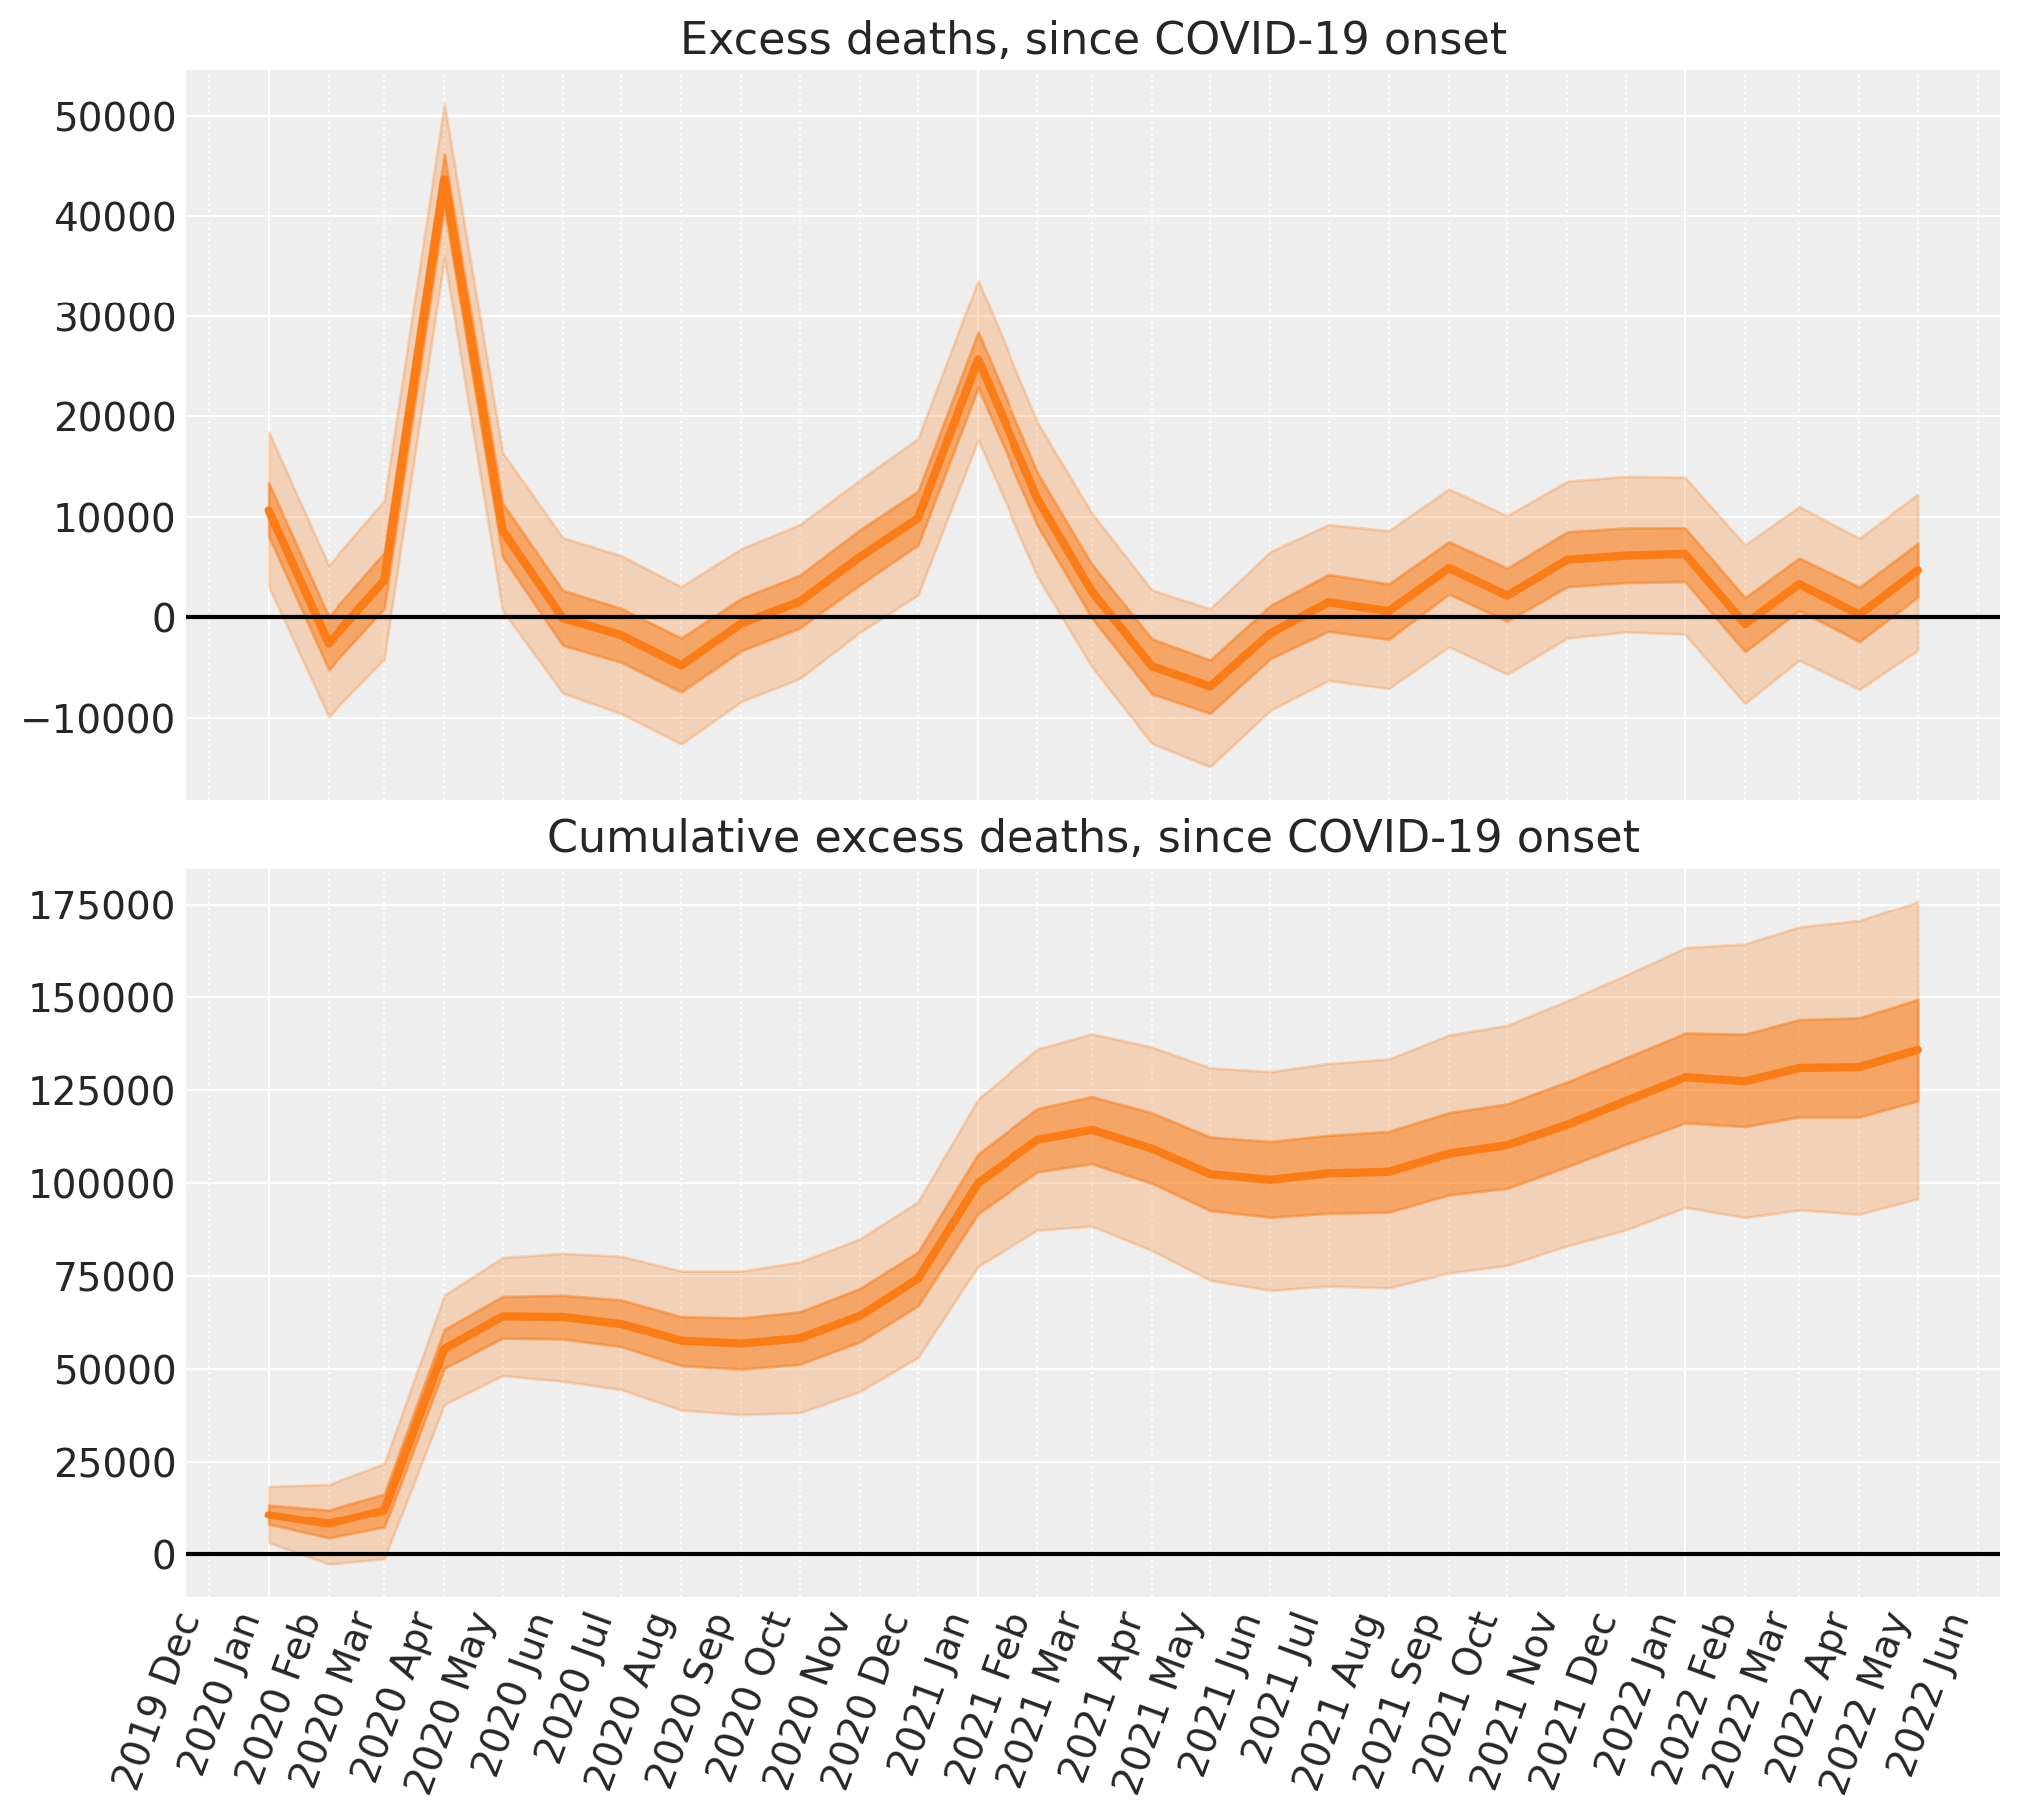

In [56]:
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(post["deaths"].to_numpy(), dims=["t"])
# do the calculation by taking the difference
excess_deaths = deaths - counterfactual.posterior_predictive["obs"]
# calculate the cumulative excess deaths
cumsum = excess_deaths.cumsum(dim="t")

fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess deaths
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, excess_deaths.transpose(..., "t"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Excess deaths, since COVID-19 onset")

# Plot the cumulative excess deaths
plot_xY(post.index, cumsum.transpose(..., "t"), ax[1])
format_x_axis(ax[1], minor=True)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative excess deaths, since COVID-19 onset");

# ZeroSumNormal 탐구

In [120]:
import numpy as np
import pytensor.tensor as pt

value_example = pt.tensor([[1.0, 2.0, 6.0, 8.0, 2.0, 6.0, 8.0], [3.0, 4.0, 6.0, 8.0, 2.0, 6.0, 8.0]], dtype=pt.float_types[0])
axis_example = 1

n_out = pt.tensor(value_example.shape[axis_example] + 1, dtype=pt.float_types[0])
print("n_out (as tensor):", n_out)

sum_vals = value_example.sum(axis_example, keepdim=True)
print(value_example)
print("sum_vals:", sum_vals)
value_example.shape, sum_vals.shape

TypeError: 'NoneType' object is not iterable

In [48]:
print(pt.sqrt(n_out) + n_out)
norm = sum_vals / (pt.sqrt(n_out) + n_out)
print("norm:", norm)

fill_val = norm - (sum_vals / pt.sqrt(n_out))
print("fill_val:", fill_val)

out = pt.concatenate([value_example, fill_val], axis=axis_example)
print("Concatenated output (before normalization):", out)

final_output = out - norm
print("Final output (after normalization):", final_output)



tensor(10.8284)
norm: tensor([[3.0475],
        [3.4169]])
fill_val: tensor([[-8.6197],
        [-9.6645]])
Concatenated output (before normalization): tensor([[ 1.0000,  2.0000,  6.0000,  8.0000,  2.0000,  6.0000,  8.0000, -8.6197],
        [ 3.0000,  4.0000,  6.0000,  8.0000,  2.0000,  6.0000,  8.0000, -9.6645]])
Final output (after normalization): tensor([[ -2.0475,  -1.0475,   2.9525,   4.9525,  -1.0475,   2.9525,   4.9525,
         -11.6673],
        [ -0.4169,   0.5831,   2.5831,   4.5831,  -1.4169,   2.5831,   4.5831,
         -13.0815]])


In [49]:
final_output.sum(1, keepdim=True)

tensor([[0.],
        [0.]])

In [57]:
def f_n(n):
    return 1 - (n - 1)/(n**0.5 + n) - 1/n**0.5
for i in range(1, 10):
    print(f"{i}: ", f_n(i))

1:  0.0
2:  0.0
3:  -1.1102230246251565e-16
4:  0.0
5:  5.551115123125783e-17
6:  -5.551115123125783e-17
7:  0.0
8:  0.0
9:  5.551115123125783e-17
